In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers,yaml

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.21.0

numpy       : 1.20.1
pandas      : 1.2.3
torch       : 1.8.1
transformers: 4.4.2
yaml        : 5.4.1



In [2]:
import os
from pathlib import Path
import sys

src_path = str(Path.cwd().parent / "src")
sys.path.append(src_path)
sys.path.append("../")
print(src_path)

/home/jupyter/hf-sentiment-analysis/src


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yaml 
from pylab import rcParams
from src.models.dataset import create_dataset
from src.models.metrics import compute_metrics
from transformers import AutoConfig, TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


In [4]:
with open("../params.yaml") as params_file:
    params = yaml.load(params_file, Loader=yaml.FullLoader)
    print(params)
    

{'global': {'ramdom_seed': 42, 'pre_trained_model_name': 'bert-base-uncased'}, 'dataset': {'apps_dataset_path': 'data/raw/apps.csv', 'reviews_dataset_path': 'data/raw/reviews.csv', 'imdb_dataset_path': 'data/raw/imbd-train.csv'}, 'split': {'train_split_path': 'data/processed/train_split.csv', 'val_split_path': 'data/processed/val_split.csv', 'test_split_path': 'data/processed/test_split.csv'}, 'models': {'imdb_bert': {'dropout': 0.3, 'linear_units': 768}}, 'train': {'train_batch_size': 8, 'valid_batch_size': 4, 'max_len_tokens': 512, 'epochs': 1, 'accumulation': 2, 'model_path': 'models/imdb_classification/'}}


In [5]:
params["split"]["train_split_path"]

'data/processed/train_split.csv'

In [6]:
df_train = pd.read_csv(f'../{params["split"]["train_split_path"]}')
df_test = pd.read_csv(f'../{params["split"]["test_split_path"]}')
df_train.head(3)

,reviews,sentiment
0,The reminder for recuurring tasks is not working.,0
1,Great app! Finally something that motivates me...,2
2,I like how it gives a different visual of my s...,2


In [7]:
df_train.shape

(21560, 2)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21560 entries, 0 to 21559
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reviews    21560 non-null  object
 1   sentiment  21560 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 337.0+ KB


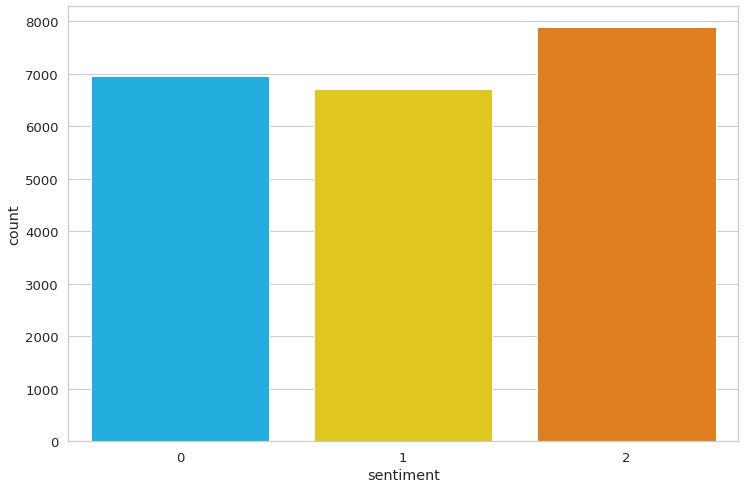

In [9]:
sns.countplot(x=df_train.sentiment);

In [10]:
tokenizer = AutoTokenizer.from_pretrained(params["global"]["pre_trained_model_name"], use_fast=True)

In [11]:
train_dataset = create_dataset(df_train, tokenizer)  

In [12]:
data = next(iter(train_dataset))
data.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [13]:
print(data["input_ids"].shape)
print(data["attention_mask"].shape)
print(data["labels"].shape)

torch.Size([512])
torch.Size([512])
torch.Size([])


In [14]:
test_dataset = create_dataset(df_test, tokenizer) 

## Model

In [15]:
model_name = params["global"]["pre_trained_model_name"]
model_config = AutoConfig.from_pretrained(
    model_name,
    num_labels=3,
    id2label={0:"negative", 1: "neutral", 2: "positive"},
    label2id={label: i for i, label in enumerate(["negative", "neutral", "positive"])},
    finetuning_task="text-classification",
)
model_config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "text-classification",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.4.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
    }

In [17]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=250,
    logging_first_step=True,
    do_train=True,
    do_eval=True,
    fp16=True,
    evaluation_strategy='steps',
)
training_args

TrainingArguments(output_dir=./results, overwrite_output_dir=False, do_train=True, do_eval=True, do_predict=False, evaluation_strategy=IntervalStrategy.STEPS, prediction_loss_only=False, per_device_train_batch_size=16, per_device_eval_batch_size=8, gradient_accumulation_steps=1, eval_accumulation_steps=None, learning_rate=5e-05, weight_decay=0.01, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=1, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=500, logging_dir=./logs, logging_strategy=IntervalStrategy.STEPS, logging_first_step=True, logging_steps=250, save_strategy=IntervalStrategy.STEPS, save_steps=500, save_total_limit=None, no_cuda=False, seed=42, fp16=True, fp16_opt_level=O1, fp16_backend=auto, fp16_full_eval=False, local_rank=-1, tpu_num_cores=None, tpu_metrics_debug=False, debug=False, dataloader_drop_last=False, eval_steps=250, dataloader_num_workers=0, past_index=-1, run_name=./results, disable_tqdm

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(params["global"]["pre_trained_model_name"], config=model_config)
model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [20]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
250,0.930100,0.714887,0.685853,216.690000,99.497000
500,0.748500,0.702174,0.694944,217.401800,99.171000
750,0.731700,0.610063,0.745083,217.752500,99.011000
1000,0.658300,0.527092,0.790909,218.081600,98.862000
1250,0.596900,0.472126,0.819712,217.949800,98.922000


In [21]:
metrics = trainer.evaluate()

In [22]:
trainer.save_metrics("eval", metrics)

In [23]:
metrics

{'eval_loss': 0.46496275067329407,
 'eval_accuracy': 0.823886827458256,
 'eval_runtime': 217.7766,
 'eval_samples_per_second': 99.001,
 'epoch': 1.0,
 'eval_mem_cpu_alloc_delta': 484451,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 1281245,
 'eval_mem_gpu_peaked_delta': 290042368}

In [27]:
# from ml_things import plot_dict

# Keep track of train and evaluate loss.
loss_history = {'train_loss':[], 'eval_loss':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with trianing loss.
    loss_history['train_loss'].append(log_history['loss'])
    
  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])

# # Plot Losses.
# plot_dict(loss_history, start_step=training_args.logging_steps, 
#           step_size=training_args.logging_steps, use_title='Loss', 
#           use_xlabel='Train Steps', use_ylabel='Values', magnify=2)

In [28]:
loss_history

{'train_loss': [1.1613, 0.9301, 0.7485, 0.7317, 0.6583, 0.5969],
 'eval_loss': [0.7148871421813965,
  0.7021740078926086,
  0.6100625395774841,
  0.5270922780036926,
  0.4721255302429199,
  0.46496275067329407]}